In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dataset Overview

In [2]:
dataset_file_path = './data/sportoclanky.csv'
assert os.path.exists(dataset_file_path)
df = pd.read_csv(dataset_file_path)

Normally I would print out `df.head()`, but since the data is too sensitive to be public, only metadata can be used for analysis.


In [3]:
df.columns

Index(['category', 'rss_title', 'rss_perex'], dtype='object')

In the background I have empirically checked that all the categories are truly unique, e.g. that there are no duplications due to case sensitivity, spelling differences, etc., and no missing values.
```
df['category'].unique()
```
The categories are indeed unique.
To be able to use the outputs publicly, I need to encode the categories. 

In [3]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
df['category_enc'] = labelencoder.fit_transform(df['category'])

In [4]:
no_classes = len(df['category_enc'].unique())
no_classes

24

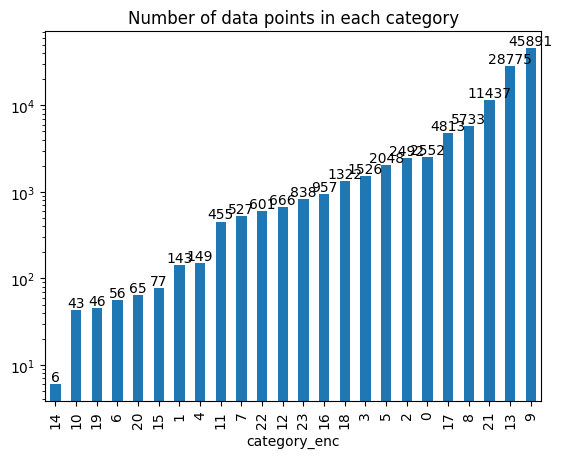

In [6]:
# count by category
cat_counts = df.groupby(['category_enc'])['rss_title'].count().sort_values()
ax = cat_counts.plot.bar(logy=True, title='Number of data points in each category')
for container in ax.containers:
    ax.bar_label(container)

In the cell outputs above we can see that the dataset contains 24 categories and is heavily imbalanced - one of the categories has only 6 datapoints while the other contains ~46K(~41% of the whole dataset)).  

Next, I would like to see if there are any outliers (some of them have been already visible in the `df.head()`) in the `rss_perex` column.
```
df[df['rss_perex'].str.len() < 20]
```
There indeed are 3500 of them. These anomalies were brought to life by mistakes during web scraping: publication date of the article, a subtitle, an author, etc. However, even the subtitles can be useful for classification in our case (e.g. 'Bundesliga' is closely associated with soccer). 

It was also beneficial to know that neither `rss_perex` nor `rss_title` have missing values.

In [19]:
len(df[df['rss_perex'].str.len() < 20])

3500

The dataset is rather large, it is also imbalanced.
Before I try any simpler methods, I use a text processing method that became highly popular in the last couple of years - transformers. Instead of training one from scratch I can use a pretrained one and utilize a latent space of its embedding to vectorize the sentences and then build a shallow network for classification.  

The main challenge is finding a suitable model for embedding the sentences - most of the widely used models are trained for the English language.
However, I was able to find multiple multi-language transformers (e.g. [Roberta](https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_L-24_H-1024_A-16/1)) and a [model trained on the Czech Wikipedia dump](https://tfhub.dev/google/wiki40b-lm-cs/1), which I decided to use. In retrospective, this was a very problematic model and I should have probably used a model [Small-E-Czech](https://huggingface.co/Seznam/small-e-czech). One of the problems, for example, was the fact that the model has an in-built tokenizer, thus the expected input is a raw sentence, however, the output is a 2d embedding of a variable length that had to be dealt with. Another concern is that, unfortunately, I have not find an available evaluation of the model, so using this model was indeed premature.   

In [5]:
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
import tensorflow_text
tf.disable_eager_execution()

In [ ]:
module_name = "https://tfhub.dev/google/wiki40b-lm-cs/1"

### Testing the embedding functionality of the model.

In [54]:
g = tf.Graph()
with g.as_default():
    # Word embeddings.
    text = tf.placeholder(dtype=tf.string, shape=(1,))
    module = hub.Module(module_name)
    embeddings = module(dict(text=text), signature="word_embeddings",
                        as_dict=True)
    embeddings = embeddings["word_embeddings"]
    init_op = tf.group([tf.global_variables_initializer(),
                      tf.tables_initializer()])
    

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [59]:
# Initialize session.
with tf.Session(graph=g).as_default() as session:
  session.run(init_op)

In [147]:
# getting the embedding size of the largest perex. 
max_index = df['rss_perex'].str.len().argmax()
longest_str = df[df.index == 9752]['rss_perex'].values[0]

In [148]:
with session.as_default():
    em = session.run(embeddings, feed_dict={text: [longest_str]})

In [149]:
np.shape(em)

(1, 635, 768)

In [7]:
embed_dim = np.shape(em)

In [39]:
em

array([[[-0.13789614, -0.4426825 ,  0.18196148, ...,  0.08833554,
          0.57045287, -0.19659606],
        [ 0.76799315, -1.3813938 ,  0.00938092, ...,  0.05473105,
         -0.05267975, -0.13432394],
        [ 0.24096207, -1.4835659 ,  0.43300864, ..., -0.36986858,
         -0.27939358, -2.4002042 ],
        ...,
        [ 1.695772  , -1.5310835 ,  2.0243015 , ...,  0.6930595 ,
          2.2788064 ,  2.9395814 ],
        [-0.9679041 ,  1.4195282 , -0.28969452, ..., -0.8922255 ,
          1.6255504 , -0.38463923],
        [-1.1023452 ,  0.6245213 , -0.8253313 , ..., -0.50677824,
          0.1268747 ,  0.04539888]]], dtype=float32)

## Training the model. 

In [ ]:
from sklearn.model_selection import train_test_split
df['text'] = df['rss_title'] + ' ' + df['rss_perex']

X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], 
                                                    df['category_enc'], 
                                                    stratify=df['category_enc'], 
                                                    random_state=42,
                                                    test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(df['clean_text'], 
                                                    df['category_enc'], 
                                                    stratify=df['category_enc'], 
                                                    random_state=42,
                                                    test_size=0.25) # 0.25 x 0.8 = 0.2   

In [8]:
class PadLayer(tf.keras.layers.Layer):
    """This layer is necessary to pad the sentences of variable size to the size of the largest embedding."""
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def pad_up_to(self, t, max_in_dims, constant_values):
        """https://stackoverflow.com/a/48535322/13591234"""
        s = tf.shape(t)
        paddings = [[0, m-s[i]] for (i,m) in enumerate(max_in_dims)]
        return tf.pad(t, paddings, 'CONSTANT', constant_values=constant_values)

    def call(self, inputs):
        output = self.pad_up_to(inputs, max_in_dims=embed_dim, constant_values=0)
        output = tf.reshape(output, embed_dim)
        return output

In [10]:
model = tf.keras.models.Sequential()
model.add(hub.KerasLayer(module_name, 
                        input_shape=[], 
                        dtype=tf.string, 
                        trainable=False, 
                        signature="word_embeddings",
                        signature_outputs_as_dict=True 
                        ))
model.add(PadLayer())
model.add(tf.keras.layers.Dense(256, activation='relu', input_shape=(embed_dim[2],)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['sparse_categorical_accuracy'])


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    {'word_embeddings': (Non  116768000 
                             e, None, 768)}                      
                                                                 
 pad_layer (PadLayer)        (1, 635, 768)             0         
                                                                 
 dense (Dense)               (1, 635, 256)             196864    
                                                                 
 flatten (Flatten)           (1, 162560)               0         
                                                                 
 dense_1 (Dense)             (1, 24)                   3901464   
                                                                 
Total params: 120,866,328
Trainable params: 4,098,328
Non-trainable params: 116,768,000
__________________________________

In retrospect, this model has probably too many parameters and lower number of parameters would have sufficed.

In [12]:
model.fit(X_train.to_numpy(), 
          y_train.to_numpy(), 
          epochs=2, 
          batch_size=1,
          validation_data=(X_val.to_numpy(),  y_val.to_numpy()))

Train on 77852 samples, validate on 33366 samples
Epoch 1/2
77852/77852 [==============================] - ETA: 0s - loss: 1.1238 - sparse_categorical_accuracy: 0.7562

c:\Users\jk\Projects\seznam_interview_challenge\env\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


77852/77852 [==============================] - 5144s 66ms/sample - loss: 1.1238 - sparse_categorical_accuracy: 0.7562 - val_loss: 1.1743 - val_sparse_categorical_accuracy: 0.7709
Epoch 2/2
77852/77852 [==============================] - 5251s 67ms/sample - loss: 1.2123 - sparse_categorical_accuracy: 0.7773 - val_loss: 1.2751 - val_sparse_categorical_accuracy: 0.7801


In [17]:
results = model.evaluate(X_test.to_numpy(), y_test.to_numpy(), batch_size=1)
print("test loss, test acc:", results)

test loss, test acc: [1.2750982523424215, 0.78007555]


The accuracy on the test data is 78%, it is not much considering how big is the dataset and the fact that 41% of the data is belongs to just one of the classes. However, the second epoch has shown some improvement in the training, thus it is probable that with higher number of epochs, the model can achieve higher precision. Unfortunately, the was needed to be short due to time and computational constraints.

The next possible steps when training the model can be: 
- changing / tweaking the model's architecture; 
- using a different embedding model; 
- utilizing the `rss_title` better, e.g. using two heads for processing `rss_title` and `rss_perex` individually.

Another thing that is left unfinished is verifying the balanced accuracy of the predictions.  

Further (quite desperate) attempt to improve results can be translating text to English (e.g. using DeepL) and then applying classic verified methods for working with text.

#### Sources for further improvements of the embeddings 
[Czech word2vec model](https://zenodo.org/record/3975038#.Y9F4MrXMJPY), 
[Training word2vec](https://textminingonline.com/training-word2vec-model-on-english-wikipedia-by-gensim), 
[Scripts for custom training of word2vec](https://github.com/anastazie/nlp_czech_wiki)

[Electra paper](https://arxiv.org/abs/2003.10555), 
[Small-e-Czech hf hub](https://huggingface.co/Seznam/small-e-czech), 
[Small-e-Czech github](https://github.com/seznam/small-e-czech),
[Roberta transformer model](https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_L-24_H-1024_A-16/1)

[Czech embeddings](https://dspace.cuni.cz/bitstream/handle/20.500.11956/147648/120397596.pdf?sequence=1),    
[An evaluation of Czech word embeddings](https://aclanthology.org/W19-6107.pdf)

#### Possible architectures can be tried from 
[Sparse categorical entropy classification](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-sparse-categorical-crossentropy-in-keras.md), 
[Pretrained Embedding Keras](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html), 
[Classifying tweets example](https://towardsdatascience.com/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81)


### Czech Wikipedia transformer model
[Embedding model](https://tfhub.dev/google/wiki40b-lm-cs/1),
[Collab](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/wiki40b_lm.ipynb#scrollTo=sv2CmI7BdaML)
